## Problem 2,  Scraping, Entropy and ICML papers.

In [1]:
# Libraries for PDF scraping
import sys
reload(sys)
sys.setdefaultencoding('utf8')
import urlparse
import urllib2
import os
from bs4 import BeautifulSoup

#Libraries for PDF preprocessing
from cStringIO import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import getopt
import string
import re

import pandas as pd
import numpy as np

### Scrape all the pdfs of all ICML 2017 papers from http://proceedings.mlr.press/v70/.

In [2]:
def download_PDFs(url, output_dir):
    try:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        request = urllib2.Request(url)
        html = urllib2.urlopen(request)
        soup = BeautifulSoup(html.read(), "lxml") #to parse the website
  
        for tag in soup.findAll('a', href=True): 
            link_str = os.path.splitext(os.path.basename(tag['href']))

            if  (link_str[1] == '.pdf') and (not link_str[0].endswith('supp')):
                current = urllib2.urlopen(tag['href'])
                print "\n[*] Downloading: %s" %(os.path.basename(tag['href']))

                f = open(output_dir + os.path.basename(tag['href']), 'w+')
                f.write(current.read())
                f.close()
    except:
            print "[*] Error."
            sys.exit(1)

In [3]:
url = "http://proceedings.mlr.press/v70/"
download_path = "./pdfs/"

#download_PDFs(url, download_path)

### Convert PDF to text

In [4]:
#converts pdf, returns its text content as a string
def convert(fname):
    pagenums = set()

    output = StringIO()
    manager = PDFResourceManager()
    converter = TextConverter(manager, output, laparams=LAParams())
    interpreter = PDFPageInterpreter(manager, converter)

    infile = file(fname, 'rb')
    for page in PDFPage.get_pages(infile, pagenums):
        interpreter.process_page(page)
    infile.close()
    converter.close()
    text = output.getvalue()
    output.close
    return text 

In [5]:
# just try for 10 pdfs...
pdfs = os.listdir("pdfs/")[:10]
# convert pdf to text
docs= [convert('./pdfs/' + name) for name in pdfs if name.endswith('.pdf')]

### Preprocess text

In [6]:
# Preproessing Text:
# There are several ways to preprocess text. 
# Many Python libraries (nltk, scikit learn, gensim,...)
# alredy have built-in functions to do it 

def preprocess(docs):
    
    #remove breaklines, convert to lowercase
    docsProc = [string.replace(docs[i], '\n', ' ') for i in range(len(docs))]
    docsProc = [u.lower() for u in docsProc]

    #remove punctuation
    docsProc = [''.join(c for c in doc if c not in string.punctuation) for doc in docsProc]

    #remove numbers
    docsProc = [re.sub("\d+", " ", doc) for doc in docsProc]

    #trim whitespace
    docsProc = [re.sub( '\s+', ' ', doc ).strip() for doc in docsProc]

    # Vectorize text by using bag of words. 
    # Notice that this function has parameters to do some of the preprocessing above...
    from sklearn.feature_extraction.text import CountVectorizer

    #read parameters of this function for text preprocessing... stopwords, lowercase, etc
    vectorizer = CountVectorizer(stop_words='english', lowercase =True)
    X = vectorizer.fit_transform(docsProc)

    # One way to easily explore frequency terms is converting X to a DAtaframe
    return pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

In [7]:
# Convert text to Bag of Words data frame
dtm = preprocess(docs)

### 1.  What are the top 10 common words in the ICML papers?

In [8]:
def top_k_words(df, k):
    
    # Sum the frequency of each word over all documents
    highest_freq = df.sum(axis=0) 
    highest_freq = highest_freq.sort_values(ascending=False) 
    
    return highest_freq[0:k]

print "Top 10 words:"
top_k_words(dtm, 10)

cid             711
al              362
et              348
algorithm       244
learning        205
optimization    199
method          149
problem         130
function        129
process         118
dtype: int64

### 2. Entropy
Let $Z$ be a randomly selected word in a randomly selected ICML paper.  Estimate the entropy of $Z$.

To estimate the entropy of $Z$ we first need to estimate the distribution of $Z$.

- Each PDF is randomly selected with probability $P(\text{paper} = i) = \frac{1}{\# \text{papers}}$.

- Let $N_i$ be the number of different words in the paper $i$.  Then P(Z=z | paper = i) can be estimated by the relative frequency of the word $z$ in paper $i$.

$$ P(Z=z |\text{paper} = i) = \frac{\text{absolute frequeny of $z$ in paper $i$}}{N_i} $$

Using the law of total probability, the marginal distribution of Z is
$$ P(Z=z) = \sum_{i \in [\# \text{papers}]} P(Z=z |\text{paper} = i) P(\text{paper} = i) = \frac{1}{\# \text{papers}} \sum_{i \in [\# \text{papers}]} P(Z=z |\text{paper} = i)$$

In [9]:
# Probability of each paper i, P(paper=i)
prob_of_paper = 1.0/dtm.shape[0]
# Total number of words in paper i, N_i
total_words_per_paper = dtm.sum(axis=1)
# Relative Frequency of each word in each paper, P(Z=z|paper=i)
relative_freqs_per_paper = dtm.divide(total_words_per_paper, axis=0)

# Marginal Probability for each word P(Z=z)
P_z = prob_of_paper*relative_freqs_per_paper.sum(axis=0)

# Entropy
entropy = -P_z.multiply(np.log(P_z)).sum()

### 3. Synthesize a random paragraph

In [10]:
# Produce a paragraph of length l
# param l: lenghth of the paragraph.
# param p: words distribution
def produce_paragraph(l, p):
    wordsIndex = [np.random.multinomial(1,p,1).argmax() for i in range(l)]
    return " ".join(p.index.values[wordsIndex])

In [11]:
produce_paragraph(100, P_z)

u'graph cpo ex eas sympo best labels granger power eqnets equivalence arbitrary using single improving reduces adds scs background bestknown lowperforming taken entropy step threedimensional max nonsmooth lin nodes contain sys puigdomenech lacostejulien steps sampling known compare bandit nonconvex default loss machine probability censoring optimal \ufb01nding theorem pp semismooth latent initial triggering support forcing reduction figure regularization hei eigenvalues easy using onc positive cid high update ski achieve human rajaratnam algorithm table algorithms bandit risk faster patient al qt information turing observed shalevshwartz optimal newton estimators vs potential table probability centered hawkes objective parametrized iterations fixs \ufb01xed ofpt information nodes'

In [12]:
import numpy
a = ['cat', 'dog']
numpy.random.choice(a, size=5, replace=True, p=[1, 0])

array(['cat', 'cat', 'cat', 'cat', 'cat'], dtype='|S3')

## Problem 3, Starting in Kaggle 
#### (2) Follow the data preprocessing steps from https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models.  Then run a ridge regression using $\alpha = 0.1$. Make a submission of this prediction, what is the RMSE you get? (Hint:  remember to exponentiate np.expm1(ypred) your predictions).

In [13]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [14]:
import os
os.chdir(".")

In [15]:
#Read the data
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

#Construct one dataset with all observations (test and train)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [16]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [17]:
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

We define a function to evaluate and compare different models using the root mean squared error (rmse) and a technique called Cross-Validation. This technique divides the trainset in k blocks (k=5 below). Then, it uses k-1 blocks for train and evaluates the model using the kth block. This procedure is repeated k times until every block has been used once as test.

CrossValidation serves as a way of proving model robustness as it shows it's sensibility to different training data. The average of the errors is the error reported and it is a way to see if the performance of the model was by chance (if in a particular test set the model performed very well it could be for some particularity of those observations)

In [18]:
#creating matrices for sklearn:

#Predictive models in sklearn receive feature observations for train, for evaluation (test) and labels for trainset
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice


#Import model functions
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet
from sklearn.model_selection import cross_val_score

# We define a function to evaluate and compare different models using the root mean squared error (rmse)

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [19]:
# We train the model just for one alpha
alpha = 0.1
cv_ridge = rmse_cv(Ridge(alpha = alpha)).mean() 

In [20]:
# Error: 
print "RMSE: "
cv_ridge

0.13777538277187923

In [21]:
#fit the model. Usually now you use the best alpha determined by CrossValidation
model_ridge = Ridge(alpha = alpha).fit(X_train,y)

#predict
ridge_preds = np.expm1(model_ridge.predict(X_test))

#Create file with predictions
solution = pd.DataFrame({"id":test.Id, "SalePrice":ridge_preds})
solution.to_csv("ridge_sol.csv", index = False)

#### (3) Compare a ridge regression and a lasso regression model. Optimize the alphas using cross validation. What is the best score you can get from a single ridge regression model and from a single lasso model?

In [22]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [23]:
model_ridge = Ridge()

In [24]:
alphas_ridge = np.linspace(1e-5, 60, 30)
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas_ridge]

alphas_lasso = np.linspace(1e-6, 1e-2, 20)
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas_lasso]

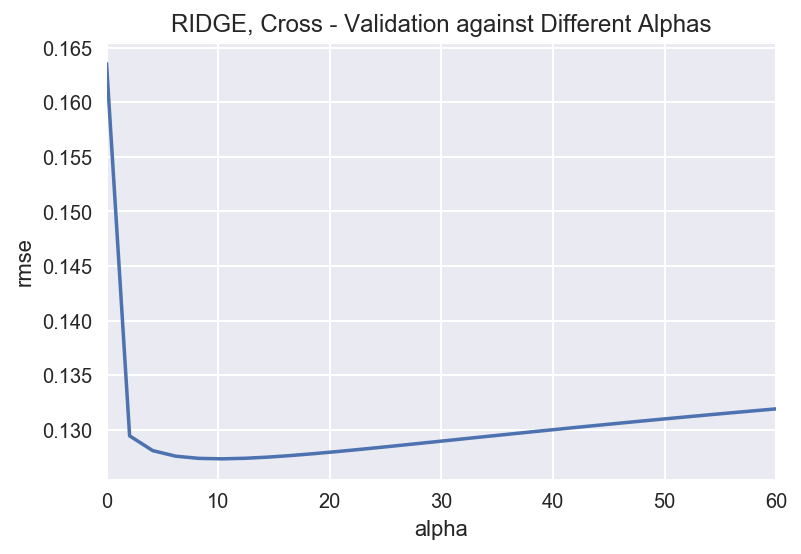

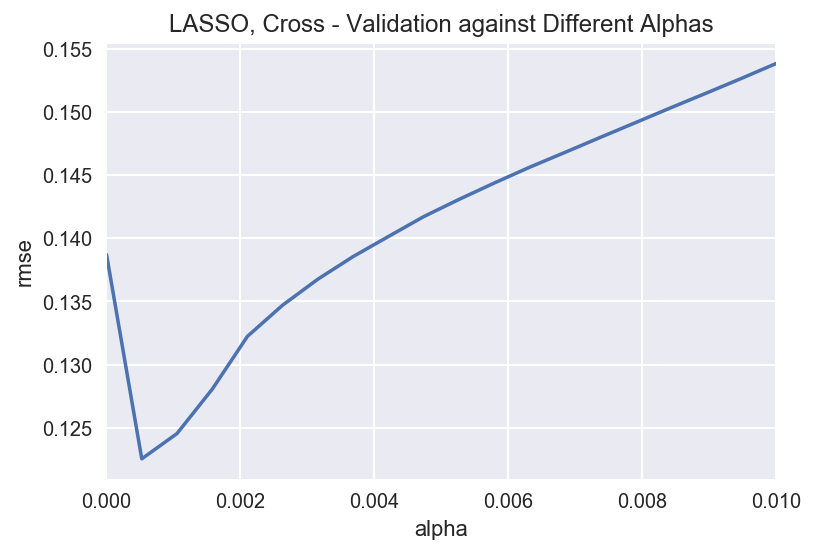

In [25]:
cv_ridge = pd.Series(cv_ridge, index = alphas_ridge)
cv_lasso = pd.Series(cv_lasso, index = alphas_lasso)

best_ridge_alpha =  cv_ridge.idxmin()
best_lasso_alpha = cv_lasso.idxmin()

print('Best Ridge RMSE {} for alpha {}'.format(cv_ridge.min(), best_ridge_alpha))
print('Best Lasso RMSE {} for alpha {}'.format(cv_lasso.min(), best_lasso_alpha))

# Ridge RMSE - Cross Validation
plt.figure();
cv_ridge.plot(title = "RIDGE, Cross - Validation against Different Alphas")
plt.xlabel("alpha")
plt.ylabel("rmse")

# Lasso RMSE - Cross Validation
plt.figure();
cv_lasso.plot(title = "LASSO, Cross - Validation against Different Alphas")
plt.xlabel("alpha")
plt.ylabel("rmse")

#### (4) Plot the l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary the strength of regularization parameter alpha.

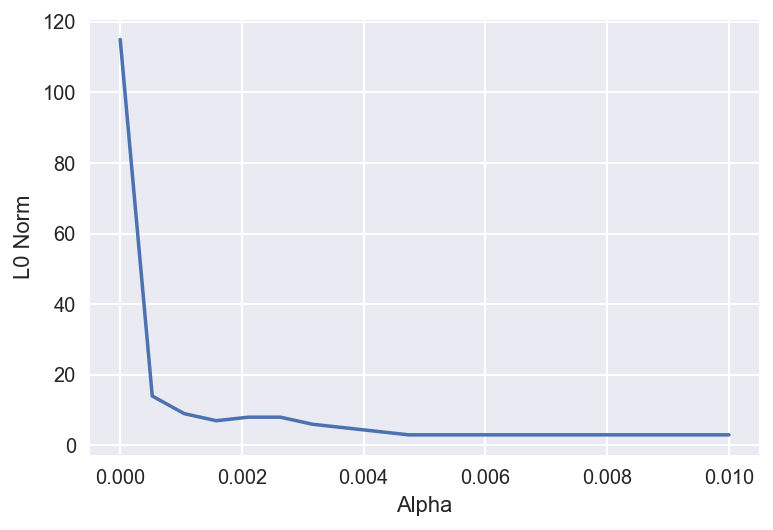

In [26]:
#alphas = [1, 0.1, 0.001, 0.0005, 1e-5, 1e-6]
cv_lasso = [rmse_cv(LassoCV(alpha).fit(X_train,y)).mean() for alpha in alphas_lasso]
coef = [LassoCV(alpha).fit(X_train,y).coef_ for alpha in alphas_lasso]
l0 = list()
for array in coef:
    l0.append(sum(array != 0))
plt.plot(alphas_lasso,l0)
plt.xlabel('Alpha')
plt.ylabel('L0 Norm')
plt.show()

#### (5) Add the outputs of your models as features and train a ridge regression on all the features plus the model outputs (This is called Ensembling and Stacking). Be careful not to overfit. What score can you get? (We will be discussing ensembling more, later in the class, but you can start playing with it now).

In [27]:
# Models
ridge_model = Ridge(best_ridge_alpha).fit(X_train,y)
lasso_model = Lasso(best_lasso_alpha).fit(X_train,y)

# Stacking
X_train_aug = X_train.copy()
X_train_aug['y_ridge'] = np.expm1(ridge_model.predict(X_train))
X_train_aug['y_lasso'] = np.expm1(lasso_model.predict(X_train))

X_test_aug = X_test.copy()
X_test_aug['y_ridge'] = np.expm1(ridge_model.predict(X_test))
X_test_aug['y_lasso'] = np.expm1(lasso_model.predict(X_test))

In [28]:
# New model
aug_model = RidgeCV(alphas_ridge).fit(X_train_aug,y) 

# New predictions
aug_preds = np.expm1(aug_model.predict(X_test_aug))

# Create file with predictions
solution = pd.DataFrame({"id":test.Id, "SalePrice":aug_preds})
solution.to_csv("aug_ridge_sol.csv", index = False)

#### (6) Install XGBoost (Gradient Boosting) and train a gradient boosting regression.

In [29]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train, y)
xgb_preds = np.expm1(xgb_model.predict(X_test))

# Create file with predictions
solution = pd.DataFrame({"id":test.Id, "SalePrice":xgb_preds})
solution.to_csv("xgb_preds.csv", index = False)